## Tutorial - Evaluate explanations during model training

This tutorial demonstrates how one can use the library to evaluate how explanations changes while a model is training. We use a LeNet model and Fashion-MNIST dataset to showcase the library's functionality.



In [1]:
# Mount Google Drive. #remove
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Install packages. #remove
!pip install captum opencv-python
!pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111  -f https://download.pytorch.org/whl/torch_stable.html

# Imports general.
import sys
import warnings
import gc
import cv2
import glob
import pathlib
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
import captum
from torchvision import transforms
from tqdm import tqdm
from captum.attr import *
import random

# Import package.
sys.path.append('/content/drive/MyDrive/Projects/xai_quantification_toolbox')
import quantus

# Notebook settings.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
warnings.filterwarnings("ignore", category=UserWarning)
%load_ext autoreload
%autoreload 2

# Collect garbage.
gc.collect()
torch.cuda.empty_cache()

Mounted at /content/drive
     |████████████████████████████████| 1.4 MB 9.0 MB/s 
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |█████████████▌                  | 834.1 MB 1.3 MB/s eta 0:14:25tcmalloc: large alloc 1147494400 bytes == 0x555716b5c000 @  0x7f3769b4d615 0x5556ddfdc4cc 0x5556de0bc47a 0x5556ddfdf2ed 0x5556de0d0e1d 0x5556de052e99 0x5556de04d9ee 0x5556ddfe0bda 0x5556de052d00 0x5556de04d9ee 0x5556ddfe0bda 0x5556de04f737 0x5556de0d1c66 0x5556de04edaf 0x5556de0d1c66 0x5556de04edaf 0x5556de0d1c66 0x5556de04edaf 0x5556ddfe1039 0x5556de024409 0x5556ddfdfc52 0x5556de052c25 0x5556de04d9ee 0x5556ddfe0bda 0x5556de04f737 0x5556de04d9ee 0x5556ddfe0bda 0x5556de04e915 0x5556ddfe0afa 0x5556de04ec0d 0x5556de04d9ee
     |█████████████████               | 1055.7 MB 1.3 MB/s eta 0:12:04tcmalloc: large alloc 1434370048 bytes == 0x55575b1b2000 @  0x7f3769b4d615 0x5556ddfdc4cc 0x5556de0bc47a 0x5556ddfdf2ed 0x5556de0d0e1d 0x5556de052e99 0x5556de04d9ee 0x5556ddfe0bda 0x55

### Load Fashion-MNIST dataset.

In [40]:
# Load datasets and make loaders.
transformer = augmentations =  transforms.Compose([transforms.RandomAffine(degrees=(0, 15), scale=(0.75, 1.25),
                                                                 interpolation=torchvision.transforms.InterpolationMode.NEAREST), 
                                         transforms.RandomHorizontalFlip(p=0.5),
                                         transforms.ToTensor()])
train_set = torchvision.datasets.FashionMNIST(root='./sample_data', train=True, transform=transformer, download=True)
test_set = torchvision.datasets.FashionMNIST(root='./sample_data', train=False, transform=transformer, download=True)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, pin_memory=True) # num_workers=4,
test_loader = torch.utils.data.DataLoader(test_set, batch_size=12, pin_memory=True)

# Specify class labels.
classes = {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}

# Load a batch of inputs and outputs to use for evaluation.
x_batch, y_batch = iter(test_loader).next()
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

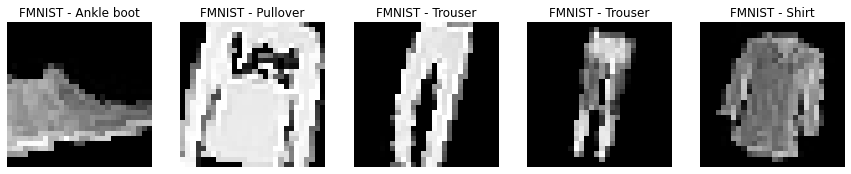

In [41]:
# Plot some inputs!

nr_images = 5
fig, axes = plt.subplots(nrows=1, ncols=nr_images, figsize=(nr_images*3, int(nr_images*2/3)))
for i in range(nr_images):
    axes[i].imshow(x_batch[i].cpu().numpy().reshape(28, 28), vmin=0.0, vmax=1.0, cmap="gray")
    axes[i].title.set_text(f"FMNIST - {classes[y_batch[i].item()]}")
    axes[i].axis("off")
plt.show()

### During model training/ fine-tuning calculate max-sensitivity scores of Integrated Gradients explanations.

In [47]:
class LeNet(torch.nn.Module):
     
    def __init__(self):   
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2, bias=True)
        self.max_pool_1 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0, bias=True)
        self.max_pool_2 = torch.nn.MaxPool2d(kernel_size=2)
        self.fc1 = torch.nn.Linear(16*5*5, 120)
        self.fc2 = torch.nn.Linear(120, 84)   
        self.fc3 = torch.nn.Linear(84, 10)    
        
    def forward(self, x):
        x = torch.nn.functional.relu(self.conv1(x))  
        x = self.max_pool_1(x)
        x = torch.nn.functional.relu(self.conv2(x))
        x = self.max_pool_2(x)
        x = x.view(-1, 16*5*5)
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Load model architecture.
model = LeNet()
print(f"\n Model architecture: {model.eval()}\n")


 Model architecture: LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (max_pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (max_pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)



In [74]:
# Set necessary configs/ parameters.
model.to(device)  
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
path_model_weights = "drive/MyDrive/Projects/xai_quantification_toolbox/tutorials/assets/fashion_mnist"
epochs = 30
nr_samples = 56
max_batches = 12
sensitivities = {}
 
for epoch in range(epochs):
    model.train()
    
    for b, (images, labels) in enumerate(test_loader):
        
        if b >= max_batches:
            break

        images, labels = images.to(device), labels.to(device)
        logits = model(images)

        loss = criterion(logits, labels)
        model.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluate model!
    predictions, labels = evaluate_model(model, x_batch.to(device), y_batch.to(device), device)
    test_acc = np.mean(np.argmax(predictions.cpu().detach().numpy(), axis=1) == labels.detach().cpu().numpy())
    
    # Explain model (on a few test samples) and measure sensitivies.
    sensitivities[epoch] = sensitivities[epoch] = quantus.MaxSensitivity(**{"nr_samples": 10,
                                                                            "perturb_radius": 0.2,
                                                                            "norm_numerator": quantus.fro_norm,
                                                                            "norm_denominator": quantus.fro_norm,
                                                                            "explain_func": quantus.explain,
                                                                            "perturb_func": quantus.uniform_sampling,
                                                                            "similarity_func": quantus.difference,
                                                                        })(model=model, 
                                                                        x_batch=x_batch[:nr_samples].cpu().numpy(),
                                                                        y_batch=y_batch[:nr_samples].cpu().numpy(),
                                                                        a_batch=None,
                                                                        **{"method": "Occlusion", "device": device, "img_size": 28, "window": (1, 2, 2)})
                                                                            
    print(f"Epoch {epoch+1}/{epochs} - loss {loss.item():.2f} - test accuracy: {(100 * test_acc):.2f}% - max sensitivity {np.mean(sensitivities[epoch]):.2f}")

# Save model.
torch.save(model.state_dict(), path_model_weights)

Epoch 1/30 - loss 0.61 - test accuracy: 75.00% - max sensitivity 0.02
Epoch 2/30 - loss 1.08 - test accuracy: 75.00% - max sensitivity 0.02
Epoch 3/30 - loss 0.41 - test accuracy: 83.33% - max sensitivity 0.01
Epoch 4/30 - loss 0.71 - test accuracy: 83.33% - max sensitivity 0.02
Epoch 5/30 - loss 0.36 - test accuracy: 75.00% - max sensitivity 0.02
Epoch 6/30 - loss 0.22 - test accuracy: 66.67% - max sensitivity 0.02
Epoch 7/30 - loss 0.42 - test accuracy: 83.33% - max sensitivity 0.02
Epoch 8/30 - loss 0.49 - test accuracy: 66.67% - max sensitivity 0.02
Epoch 9/30 - loss 0.40 - test accuracy: 83.33% - max sensitivity 0.02
Epoch 10/30 - loss 0.57 - test accuracy: 75.00% - max sensitivity 0.02
Epoch 11/30 - loss 0.54 - test accuracy: 91.67% - max sensitivity 0.02
Epoch 12/30 - loss 0.59 - test accuracy: 66.67% - max sensitivity 0.02
Epoch 13/30 - loss 0.50 - test accuracy: 83.33% - max sensitivity 0.02
Epoch 14/30 - loss 0.40 - test accuracy: 83.33% - max sensitivity 0.02
Epoch 15/30 - l

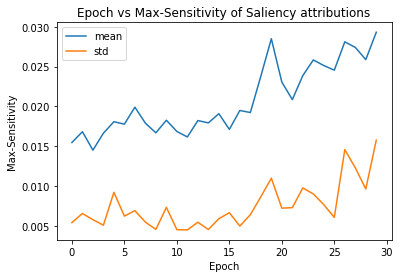

In [76]:
# Summarise in a dataframe.      
df = pd.DataFrame()
df["mean"] = pd.DataFrame(sensitivities).mean(axis=0)
df["std"] = pd.DataFrame(sensitivities).std(axis=0)

# Plot!
df.plot.line(title="Epoch vs Max-Sensitivity of Occlusion attributions", xlabel="Epoch", ylabel="Max-Sensitivity")